<a href="https://colab.research.google.com/github/dainis-boumber/av/blob/master/pretrain_av.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ULMFiT + Siamese Network for Sentence Vectors
## Part One: Tokenizing
This notebook will tokenize the sentences from the SNLI dataset for use in the next notebook

### You must have the fastai library installed

In [15]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from ipyexperiments import *
from fastai.text import *
from fastai import *
import json
import html
import re
import pickle
import random
import pandas as pd
import numpy as np
from pathlib import Path
import sklearn
from sklearn import model_selection
from functools import partial
from collections import Counter, defaultdict
from pandas.io.json import json_normalize
import numpy as np
import torch
import torch.nn as nn
import torch.utils 
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import dataset, dataloader
import torch.optim as optim
import torch.nn.functional as F
from nltk.tokenize import  sent_tokenize
import time
import math
import sys
import data
import joblib
from random import shuffle
from itertools import permutations, combinations

token_files = './data/PAN14/tokens/'
model_files = './data/PAN14/models/'

TRAINDATAPATH = "./data/PAN14/pan14_train_english-essays/"
TESTDATAPATH = "./data/PAN14/pan14_test02_english-essays/"
FNAMES = ['known01','known02','known03','known04','known05', 'unknown']
KCOLS=['known01','known02','known03','known04','known05']
LABELCOL="answer"
UNKOWN="unknown"
np.random.seed=42

In [16]:
BOD = 'x_bod' # beginning-of-doc tag

re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def read_dataset(path):
    ds=pd.read_json(path+'/truth.json')
    ds=json_normalize(ds['problems'])
    ds['known01']=None
    ds['known02']=None
    ds['known03']=None
    ds['known04']=None
    ds['known05']=None
    ds['unknown']=None
    ds.set_index('name', drop=True, inplace=True)
    ds=ds[['known01','known02','known03','known04','known05', 'unknown', 'answer']]
    dirs = []
    docs = []

    for i, x in enumerate(os.walk(path)):
        if i:
            for fname in x[2]:
                with open(path+dirs[i-1]+'/'+fname, 'r') as f:
                    text = f.read().strip()
                    doc = ' '.join(sent_tokenize(text)).strip()
                    ds.loc[dirs[i-1],fname[:-4]]=doc
        else:
            dirs = x[1]

    return ds

def match_unknowns(path):
    ds=pd.read_json(path+'/truth.json')
    ds=json_normalize(ds['problems'])
    ds['known01']=None
    ds['known02']=None
    ds['known03']=None
    ds['known04']=None
    ds['known05']=None
    ds['unknown']=None
    ds.set_index('name', drop=True, inplace=True)
    ds=ds[['known01','known02','known03','known04','known05', 'unknown', 'answer']]
    dirs = []
    docs = []

    ds = read_dataset(path)
            
    grouped=ds.groupby(['unknown'])
    dupes=[]
    for utext, group in grouped:
        if len(group.index) > 1:
            dupes.append(group)


    newrows=pd.DataFrame(columns=['known01','known02','known03','known04','known05', 'unknown'])
    for dupe in dupes:
        dupe.reset_index(drop=True, inplace=True)
        yes=dupe.loc[dupe.answer == "Y"]
        yes.reset_index(drop=True, inplace=True)
        no=dupe.loc[dupe.answer == "N"]
        no.reset_index(drop=True, inplace=True)
        for col in ['known01','known02','known03','known04','known05']:
            if no[col] is not None:
                newrows=newrows.append(pd.DataFrame(data={'known01':yes.known01,'known02':yes.known02,
                                                          'known03':yes.known03, 'known04':yes.known04,
                                                          'known05':yes.known05,'unknown':no[col], 
                                                          'answer':'N'}), sort=False)
    newrows=newrows.dropna(subset=['unknown'])
    df = pd.concat([ds, newrows])

    return df


def shuffle_text(text, n=4):
    pars = [text[i:i+int(len(text)/n)] for i in range(0, len(text), int(len(text)/n))]
    shuffle(pars)
    return ''.join(pars)


def load_doc_pairs(df, augment=False):
   
    s0s = []
    s1s = []
    labels = [1 if label == 'Y' else 0 for label in df[LABELCOL].tolist()]
    
    y=[]
    unknowns = df[UNKOWN].tolist()
    for i, label in enumerate(labels):
        for col in KCOLS:
            knowns = df[col].tolist()

            s0 = knowns[i]
            if s0 is not None:
                s1 = unknowns[i]
                s0s.append(s0)
                s1s.append(s1)
                y.append(label)
                
                if augment:
                    s0inflated=shuffle_text(s0)
                    s1inflated=shuffle_text(s1)
                    s0s.append(s0inflated)
                    s1s.append(s1inflated)
                    y.append(label)
    data = pd.DataFrame(data={"known":s0s, "unknown":s1s, "label":y}) 
    
    return data



df_train = read_dataset(TRAINDATAPATH)
df_test = read_dataset(TESTDATAPATH)

In [17]:

doc_pairs_train = load_doc_pairs(df_train, False)

doc_pairs_val = load_doc_pairs(df_test, False)
doc_pairs_test = load_doc_pairs(df_test, False)



In [18]:
joblib.dump(doc_pairs_train, f'{model_files}traindf-1.pkl')
joblib.dump(doc_pairs_val, f'{model_files}valdf-1.pkl')
joblib.dump(doc_pairs_test, f'{model_files}testdf-1.pkl')


['./data/PAN14/models/testdf-1.pkl']

In [ ]:
doc_pairs_train.to_csv(f'{model_files}train.csv)

In [5]:



# Language model data
data_lm = TextLMDataBunch.from_df(model_files, doc_pairs_train, doc_pairs_val, text_cols=['known', 'unknown'],
                                  label_cols=['label'], mark_fields=True, bs=64)

data_lm.save()

In [9]:

exp1=IPyExperimentsPytorch()
data_lm = TextLMDataBunch.load(model_files)
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.7, metrics=[accuracy],
                              callback_fns=ShowGraph)

#learn.lr_find(start_lr=1e-07,end_lr=10, num_it=100)
#learn.recorder.plot()



*** Experiment started with the Pytorch backend
Device: ID 0, GeForce GTX 1070 (8117 RAM)


*** Current state:
RAM:  Used  Free  Total      Util
CPU:  2590 57378  64352 MB   4.03% 
GPU:  1765  6351   8117 MB  21.75% 


･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.138
･ CPU:         0       0     2590 MB |
･ GPU:         0       0     1765 MB |

IPyExperimentsPytorch: Finishing

*** Experiment finished in 00:02:28 (elapsed wallclock time)

*** Newly defined local variables:
Deleted: learn

*** Experiment memory:
RAM:  Consumed     Reclaimed
CPU:     124       0 MB (  0.00%)
GPU:     805       0 MB (  0.00%)

*** Current state:
RAM:  Used  Free  Total      Util
CPU:  2590 57379  64352 MB   4.03% 
GPU:  1765  6351   8117 MB  21.75% 


･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:01.055
･ CPU:         0       0     2631 MB |
･ GPU:        42       0     1807 MB |


epoch,train_loss,valid_loss,accuracy
1,3.838166,3.626829,0.307396
2,3.539490,3.556839,0.315221


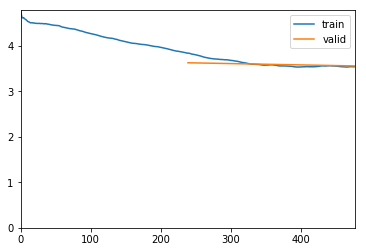

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:01:45.699
･ CPU:         0       0     2631 MB |
･ GPU:       193    1535     2001 MB |


In [10]:
learn.fit_one_cycle(2, max_lr=1e-02, moms=(0.8, 0.7))

In [56]:
0.326599

0.326599

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.006
･ CPU:         0       0     2677 MB |
･ GPU:         0       0     2772 MB |


In [11]:
learn.save('a4')

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.106
･ CPU:         0       0     2631 MB |
･ GPU:         0       0     2001 MB |


epoch,train_loss,valid_loss,accuracy
1,3.375003,3.518180,0.319739
2,3.249561,3.460346,0.327076
3,3.029946,3.408157,0.335485
4,2.848306,3.379924,0.340204
5,2.683799,3.365690,0.343275
6,2.602946,3.366467,0.343415


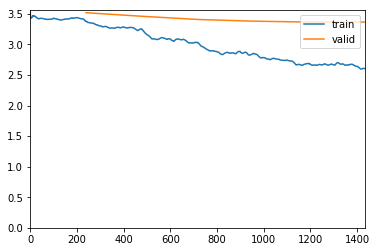

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:06:20.137
･ CPU:         1       0     2632 MB |
･ GPU:       548    1292     2550 MB |


In [12]:

learn.load('a4')
learn.unfreeze()
learn.fit_one_cycle(6, slice(5e-3),  moms=(0.8, 0.7))

In [13]:
learn.save('a4lm')
learn.save_encoder('a4enc')

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.285
･ CPU:         0       0     2632 MB |
･ GPU:         0       0     2549 MB |


In [14]:
del exp1

･ RAM: △Consumed △Peaked  Used Total | Exec time 0:00:00.000
･ CPU:         0       0     2632 MB |
･ GPU:         0       0     2549 MB |

IPyExperimentsPytorch: Finishing

*** Experiment finished in 00:10:29 (elapsed wallclock time)

*** Experiment memory:
RAM:  Consumed     Reclaimed
CPU:      41       0 MB (  0.00%)
GPU:     784       0 MB (  0.00%)

*** Current state:
RAM:  Used  Free  Total      Util
CPU:  2632 57303  64352 MB   4.09% 
GPU:  2549  5567   8117 MB  31.41% 


